In [92]:
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros

import matplotlib.pyplot as plt
import string
import pandas as pd
import gensim
from sklearn.model_selection import train_test_split
from io import StringIO
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers 
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Conv1D, GlobalMaxPooling1D, LSTM
from keras.layers.core import Activation, Dropout, Dense

MAX_WORDS = 15000

In [93]:
np.__file__

'/home/dalbosta/anaconda3/envs/conda_env/lib/python3.7/site-packages/numpy/__init__.py'

PREPARE LABELS

In [94]:
df = pd.read_json("trump_tweets_11_17.json")
replacement_dict = {"Twitter for iPhone": 1, "Twitter for Android": 0}
df = df.replace(to_replace=replacement_dict)   # replace labels
df = df[df.source.apply(lambda x: type(x) == int)]  # remove tweets from other sources
df = df.sample(frac=1)

Split into training and testing

In [95]:
all_texts = df.sample(frac=1, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    all_texts['text'], 
    all_texts['source'], 
    test_size=0.20, 
    random_state=42)

Tokenize Text for Embedding Layer

In [96]:
#create word-to-index dictionary
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


dictionary = tokenizer.word_index

In [97]:
#length of current dictionary vocab
vocab_size = len(tokenizer.word_index) + 1

maxlen = 65

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [126]:
#construct embeddings using GlOve
embeddings_dictionary = dict()

#file is too large to store on git, must download and place in folder manually
glove_file = open('../glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [99]:
#create embedding matrix
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [100]:
vocab_size == len(embedding_matrix)

True

# Feed Forward Network

In [101]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [102]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 65, 100)           2452400   
_________________________________________________________________
flatten_3 (Flatten)          (None, 6500)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6501      
Total params: 2,458,901
Trainable params: 6,501
Non-trainable params: 2,452,400
_________________________________________________________________
None


In [103]:
history = model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)

Train on 11903 samples, validate on 2976 samples
Epoch 1/15
11903/11903 [==============================] - 0s 32us/step - loss: 0.4050 - acc: 0.8015 - val_loss: 0.3369 - val_acc: 0.8427
Epoch 2/15
11903/11903 [==============================] - 0s 13us/step - loss: 0.3175 - acc: 0.8461 - val_loss: 0.3097 - val_acc: 0.8518
Epoch 3/15
11903/11903 [==============================] - 0s 13us/step - loss: 0.2911 - acc: 0.8610 - val_loss: 0.2993 - val_acc: 0.8518
Epoch 4/15
11903/11903 [==============================] - 0s 13us/step - loss: 0.2749 - acc: 0.8717 - val_loss: 0.2946 - val_acc: 0.8522
Epoch 5/15
11903/11903 [==============================] - 0s 13us/step - loss: 0.2631 - acc: 0.8799 - val_loss: 0.2932 - val_acc: 0.8528
Epoch 6/15
11903/11903 [==============================] - 0s 14us/step - loss: 0.2538 - acc: 0.8816 - val_loss: 0.2931 - val_acc: 0.8552
Epoch 7/15
11903/11903 [==============================] - 0s 13us/step - loss: 0.2468 - acc: 0.8879 - val_loss: 0.2889 - val_acc:

In [104]:
score = model.evaluate(X_test, y_test, verbose=1)

3720/3720 [==============================] - 0s 28us/step


In [105]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3235545777505444
Test Accuracy: 0.851344108581543


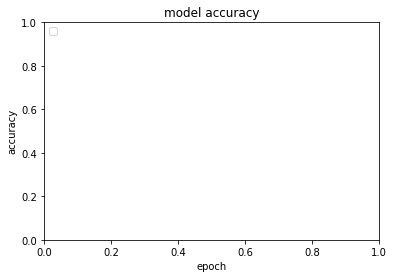

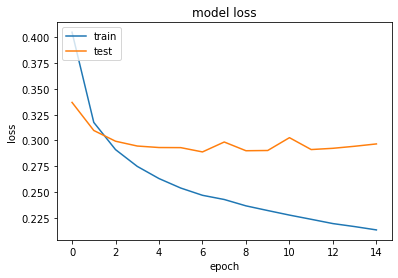

In [106]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# CNN

In [107]:
cnn = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn.add(embedding_layer)

cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [108]:
print(cnn.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 65, 100)           2452400   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 61, 128)           64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 2,516,657
Trainable params: 64,257
Non-trainable params: 2,452,400
_________________________________________________________________
None


In [109]:
history = cnn.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)

score = cnn.evaluate(X_test, y_test, verbose=1)

Train on 11903 samples, validate on 2976 samples
Epoch 1/15
11903/11903 [==============================] - 1s 63us/step - loss: 0.4040 - acc: 0.8185 - val_loss: 0.3353 - val_acc: 0.8458
Epoch 2/15
11903/11903 [==============================] - 0s 34us/step - loss: 0.2892 - acc: 0.8747 - val_loss: 0.3112 - val_acc: 0.8642
Epoch 3/15
11903/11903 [==============================] - 0s 35us/step - loss: 0.2370 - acc: 0.9030 - val_loss: 0.2855 - val_acc: 0.8747
Epoch 4/15
11903/11903 [==============================] - 0s 34us/step - loss: 0.1992 - acc: 0.9261 - val_loss: 0.2728 - val_acc: 0.8810
Epoch 5/15
11903/11903 [==============================] - 0s 33us/step - loss: 0.1637 - acc: 0.9456 - val_loss: 0.2768 - val_acc: 0.8790
Epoch 6/15
11903/11903 [==============================] - 0s 34us/step - loss: 0.1365 - acc: 0.9590 - val_loss: 0.2729 - val_acc: 0.8774
Epoch 7/15
11903/11903 [==============================] - 0s 35us/step - loss: 0.1115 - acc: 0.9720 - val_loss: 0.2660 - val_acc:

In [110]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3237013157657398
Test Accuracy: 0.8892472982406616


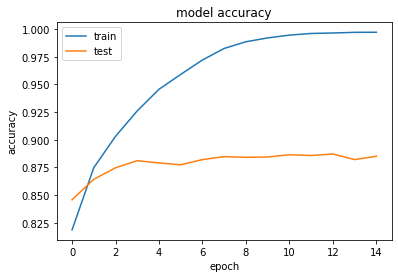

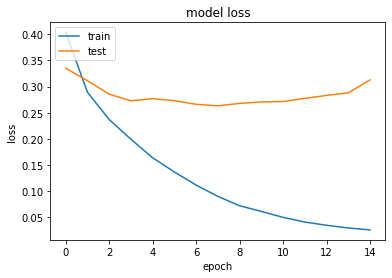

In [111]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# LSTM model

In [112]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [113]:
y_train

14269    0
16680    0
12035    1
11677    1
18324    0
        ..
14096    1
14729    0
17980    0
14114    0
5544     1
Name: source, Length: 14879, dtype: object

In [114]:
print(lstm_model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 65, 100)           2452400   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 2,569,777
Trainable params: 117,377
Non-trainable params: 2,452,400
_________________________________________________________________
None


In [115]:
history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)

score = lstm_model.evaluate(X_test, y_test, verbose=1)

Train on 11903 samples, validate on 2976 samples
Epoch 1/15
11903/11903 [==============================] - 5s 443us/step - loss: 0.4656 - acc: 0.7755 - val_loss: 0.3548 - val_acc: 0.8377
Epoch 2/15
11903/11903 [==============================] - 4s 325us/step - loss: 0.3595 - acc: 0.8225 - val_loss: 0.3143 - val_acc: 0.8427
Epoch 3/15
11903/11903 [==============================] - 4s 332us/step - loss: 0.3405 - acc: 0.8169 - val_loss: 0.3336 - val_acc: 0.8115
Epoch 4/15
11903/11903 [==============================] - 4s 337us/step - loss: 0.3151 - acc: 0.8378 - val_loss: 0.2986 - val_acc: 0.8555
Epoch 5/15
11903/11903 [==============================] - 4s 337us/step - loss: 0.2925 - acc: 0.8595 - val_loss: 0.2850 - val_acc: 0.8609
Epoch 6/15
11903/11903 [==============================] - 4s 338us/step - loss: 0.2894 - acc: 0.8568 - val_loss: 0.2829 - val_acc: 0.8508
Epoch 7/15
11903/11903 [==============================] - 4s 358us/step - loss: 0.2767 - acc: 0.8655 - val_loss: 0.2623 - v

In [116]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2479386975688319
Test Accuracy: 0.8860214948654175


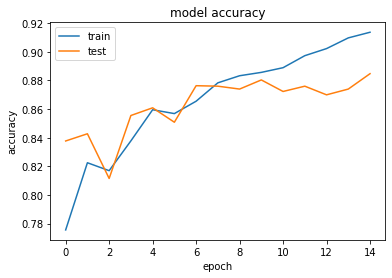

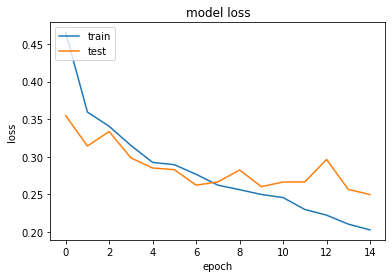

In [117]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [121]:
lstm_model.predict(X_test)[2]

array([0.3353365], dtype=float32)

In [124]:
y_test

11278    1
17501    1
10908    1
3094     1
930      1
        ..
8082     1
6950     1
8426     1
14928    0
15465    0
Name: source, Length: 3720, dtype: object